# Introdução

Nesta atividade vamos seguir aproximadamente o material do livro-texto da disciplina (Géron, capítulo 2), e o notebook do material de suporte do livro em https://github.com/ageron/handson-ml .

Sua missão é prever o valor mediano de imóveis em distritos residenciais da Califórnia, baseado em algumas características.

O conjunto de dados vem do censo de 1990 da Califórnia: preços hoje em dia estão radicalmente diferentes!

# Entendendo o problema

Antes de começar a trabalhar no problema, tente entender o contexto no qual o problema se insere. Por que desejamos prever os preços medianos dos imóveis? No livro, o autor menciona que neste exemplo fictício estamos desenvolvendo um preditor de preços medianos como um subsistema de um sistema de auxílio à tomada de decisão em investimentos imobiliários. 

No livro, o autor também menciona que o sistema atual da empresa usa estimativas manuais, com um erro de cerca de 15%. Um sistema de machine learning pode, potencialmente, ser mais barato, mais rápido e mais preciso!

Você consegue pensar em outros motivos?

**R:** 

 - Adaptar-se a mudanças de modo automático
 - Escalabiidade
 - Portabilidade do Sistema (mas não dos dados)
 - Descoberta de anomalias

Que tipo de problema temos aqui, do ponto de vista de machine learning:

- Aprendizado supervisionado ou não-supervisionado?

- Classificação ou regressão?

**R:**
 - Supervisionado (temos o preço atual de casas)
 - Regressão (variável sequêncial, quantitativa)
 

Agora, selecione a medida de desempenho do seu sistema de machine learning. É importante escolher a medida de performance antes de trabalhar com o problema, para que essa escolha seja idônea. Se deixarmos a escolha para mais tarde, depois de conhecer nossos dados em detalhe, pode ser que sejamos tentados a escolher a medida de performance que nos pareça mais favorável para exibir um "bom" desempenho! Isso não é ciência!

Neste problema vamos escolher a raiz quadrada do erro médio quadrático como medida de erro (RMSE - Root Mean Squared Error). Sejam $X = (x_1, x_2, \cdots, x_m)$  e $y = (y_1, y_2, \cdots, y_m)$ nossos conjuntos de testes, onde 

- $X$ contém as características dos distritos e

- $y$ contém os valores medianos de imóveis nos correspondentes distritos. 

Seja também $h(x)$ o nosso modelo preditivo de valores medianos de imóveis, que foi obtido através de ajuste (fit) de modelo à partir das amostras de treinamento.

Então RMSE é dado por:

$$RMSE(X, y, h) = \sqrt{\frac{1}{m} \sum_{i=1}^{m}\left(h(x_i) - y_i\right)^{2}}$$

Pergunta: por que elevar ao quadrado? Por que aplicar a raiz quadrada?

**R:** 

 - Para que erros negativos não "anulem" os positivos.
 - Para manter a mesma unidade de medida e valores.

# Inicializando o código

Na maioria dos nossos trabalhos vamos usar as bibliotecas:

- Pandas: uma biblioteca para análise de dados em Python. https://pandas.pydata.org/

- NumPy: computação científica em Python. http://www.numpy.org/

- Matplotlib: para gráficos e outras visualizações

Atenção: mais adiante vamos acabar inevitavelmente misturando o uso de duas estruturas de armazenamento de dados em tabelas: DataFrames (Pandas) e ndarrays (NumPy), fique atento!

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Vamos fixar a semente do gerador de números aleatórios, para ter reproducibilidade neste notebook. 

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Carregando dados

No livro o autor descreve a necessidade da automação no processo de adquirir e armazenar dados. Isso é muito importante sim! Para simplificar o trabalho de hoje vamos pular esta etapa, e carregar diretamente o arquivo de dados fornecido pelo professor, mas recomendo a leitura e reflexão acerca do material do livro. Afinal, são dicas valiosas de quem esteve "nas trincheiras", e eu assino embaixo das dicas dele.

Por ora vamos apenas carregar o arquivo CSV:

In [4]:
HOUSING_FILE = 'housing.csv'

def load_housing_data(housing_file=HOUSING_FILE):
    return pd.read_csv(housing_file)

housing = load_housing_data()

A função retorna um DataFrame do Pandas:

In [5]:
type(housing)

pandas.core.frame.DataFrame

Um DataFrame é uma tabela com linhas e colunas nomeadas (opcionalmente), e contém vários métodos para indexação, slicing, estatísticas, e muito mais. https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html

# Entendendo inicialmente os dados

Cada linha da tabela representa um distrito da Califórnia. Vamos conhecer mais sobre os dados:

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing.head(n=10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


Perguntas:

- Quantos distritos existem na base?

- Qual é a coluna de valores dependentes?

- Tem valor faltante?

- O que representam as colunas "total_rooms", "total_bedrooms", e "households"?

In [8]:
housing.count()
# 20640 distritos
# median_house_value
# sim, em total_bedrooms

longitude             20640
latitude              20640
housing_median_age    20640
total_rooms           20640
total_bedrooms        20433
population            20640
households            20640
median_income         20640
median_house_value    20640
ocean_proximity       20640
dtype: int64

**R:**

Para ganhar um entendimento melhor da distribuição dos dados:

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Note que a coluna "ocean_proximity" não aparece aqui, pois trata-se de uma coluna não-numérica. Apenas as colunas numéricas estão presentes, e a coluna "ocean_proximity" indica rótulos - trata-se de dados categóricos. 

Para analisar colunas com dados categóricos, podemos usar o método ``value_counts()`` na *série* associada à coluna de interesse:

In [10]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [11]:
type(housing['ocean_proximity'])

pandas.core.series.Series

Se as estatisticas descritivas sumárias do método ``describe()`` não são suficientes para se obter uma visão dos dados, tente histogramas:

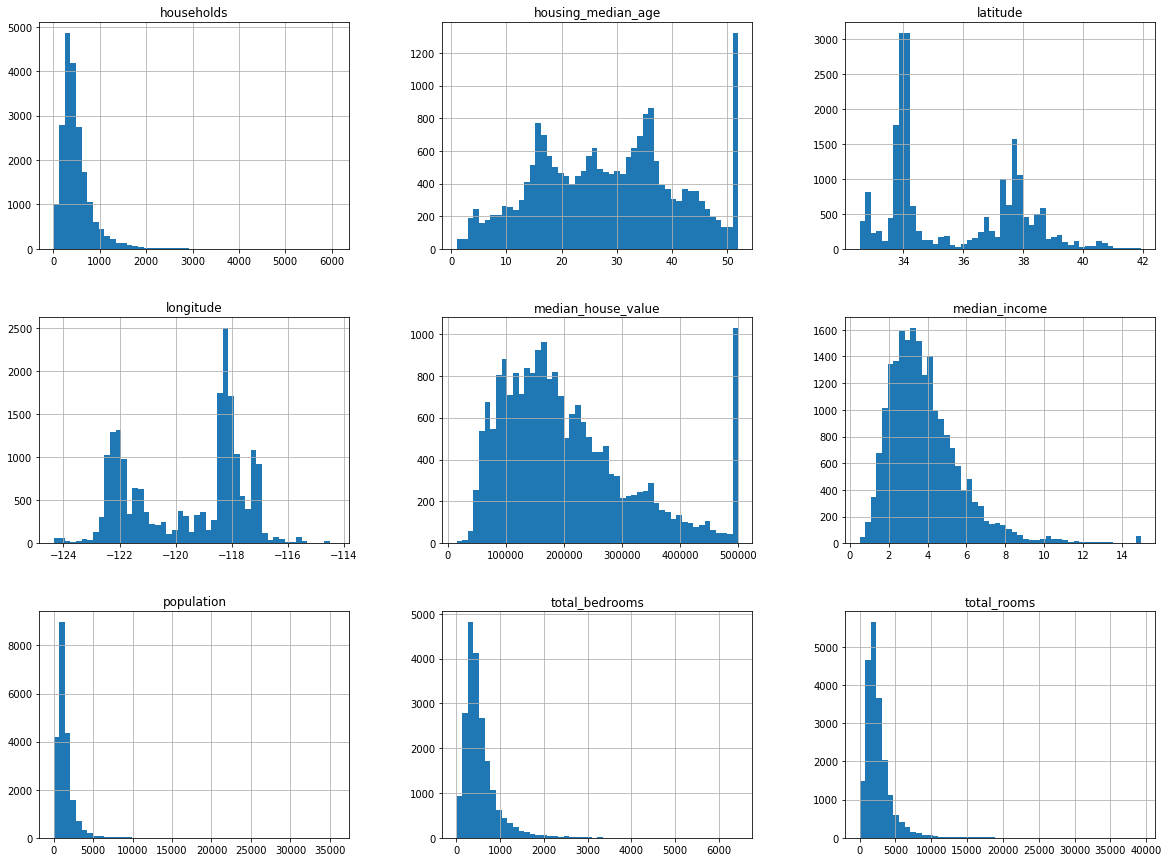

In [12]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

Perguntas:

- Notou alguma anomalia? Qual? Por que você acha que isso aconteceu?

- Quais são as unidades de medida de cada coluna?

- Este dataset tem um problema sério: o preço mediano dos imóveis foi artificialmente limitado em 500k. Talvez no formulário de pesquisa de dados tivesse uma opção, na seção "Preço do imóvel", onde estava escrito "mais de 500k". Como garantir que o sistema funcionará para prever preços acima de 500k?

**R:**

 - median_house_value e housing_median_age, talvez por ser um distrito histórico
 - jj
 - extrapolando os dados menores do que 500k até o mesmo, aproximando a amostra de uma conhecida (como a normal)

***PARE!***

Antes de prosseguir, devemos dividir nossos dados em duas partes: conjunto de treinamento e de testes! *E devemos jurar solenemente que jamais vamos explorar o conjunto de testes, devemos utilizá-lo apenas para as medidas finais de desempenho do nosso sistema!*

Tal medida se faz necessária para evitar overfitting, mesmo sem querer! Pode ser que observemos algum padrão nos dados de teste e incorporemos este padrão (inconscientemente) nas nossas decisões de projeto do modelo de machine learning. Então nosso resultado final será otimista demais, e nosso sistema não terá um desempenho tão bom em produção. À esse tipo de viés induzido por ter "espiado" os dados de teste chamamos ****data snooping bias****

# Dividindo os dados em conjunto de treinamento e de testes

Para selecionar um conjunto de testes, basta escolher aleatoriamente algumas amostras do conjunto original. Tipicamente selecionamos 20% da amostra para testes. Os demais pontos de dados serão o conjunto de treinamento.

Isto pode ser feito com Scikit-Learn usando a função ``train_test_split()``:

In [13]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=RANDOM_SEED)

In [14]:
print('{} train + {} test'.format(len(train_set), len(test_set)))

16512 train + 4128 test


Normalmente isso basta.

Porém, o livro tece várias considerações de natureza prática a respeito de como fazer uma boa separação entre conjuntos de treinamento e teste. Em particular:

- Separação por valor de hash: quando estamos em um ambiente onde o conjunto de dados cresce a cada dia (como no caso do autor do livro, que era do time de machine learning do YouTube), é importante ter uma política de seleção de dados de teste que não permita que itens de teste migrem para o conjunto de treinamento ao se fazer uma nova amostragem dos dados.

- Separação estratificada: quando é importante garantir representatividade proporcional aproximadamente igual nos conjuntos de treinamento e teste, em relação a algum atributo, devemos usar separação estratificada. Por exemplo: se queremos dividir um grupo de pacientes em um experimento entre conjuntos de controle e de tratamento, devemos usar separação estratificada em relação ao sexo dos participantes.

O código abaixo faz separação estratificada em relação à uma variável categórica inventada que se relaciona com a renda média:

In [15]:
# Constroi uma coluna nova com categorias de renda fictícias.
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

# Divide, de modo estratificado, o conjunto de dados.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Remove a coluna nova, que foi adicionada apenas temporariamente.
strat_train_set.drop(['income_cat'], axis=1, inplace=True)
strat_test_set.drop(['income_cat'], axis=1, inplace=True)

In [16]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [17]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 5241 to 2398
Data columns (total 10 columns):
longitude             4128 non-null float64
latitude              4128 non-null float64
housing_median_age    4128 non-null float64
total_rooms           4128 non-null float64
total_bedrooms        4079 non-null float64
population            4128 non-null float64
households            4128 non-null float64
median_income         4128 non-null float64
median_house_value    4128 non-null float64
ocean_proximity       4128 non-null object
dtypes: float64(9), object(1)
memory usage: 354.8+ KB


A partir de agora usaremos os conjuntos strat_train_set e strat_test_set. O conjunto strat_train_set será usado para várias explorações e para construir nosso modelo preditivo. O conjunto strat_test_set será usado só no final do projeto, para avaliar a performance final do nosso modelo.

# Explorando melhor os dados de treinamento

Nossa missão agora é construir um modelo preditivo à partir dos exemplos do conjunto de treinamento. Para isso, devemos:

- Visualizar e explorar os dados para entendê-los melhor

- Preparar os dados para machine learning

- Escolher uma boa família de modelos

- Treinar os modelos, fazer ajuste fino dos hiperparâmetros.

Para explorar os dados é recomendável que você separe um pedaço do conjunto de treinamento para explorar. O motivo é prático: fica mais rápido iterar sobre os dados, visualizar, etc! Como este dataset é minúsculo (para os padrões de machine learning), vamos explorar o conjunto de treinamento inteiro mesmo.

In [18]:
housing = strat_train_set.copy()

### Dados geográficos

Vamos visualizar os dados geográficos, para começar:

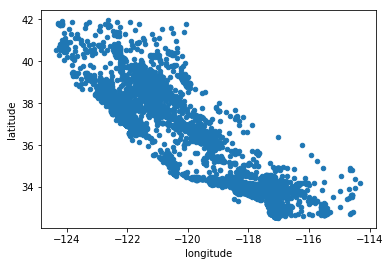

In [19]:
housing.plot(kind='scatter', x='longitude', y='latitude')
plt.show()

Como temos muitos dados agrupados, fica difícil distinguir a real densidade de pontos.

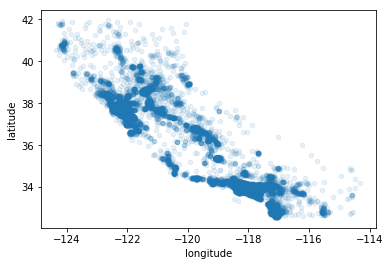

In [20]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
plt.show()

Opa, agora melhorou!

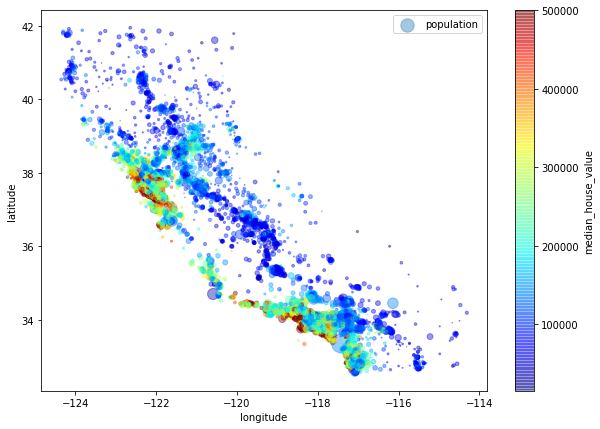

In [21]:
housing.plot(
    kind="scatter", 
    x="longitude", y="latitude", s=housing["population"]/100, 
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    label="population", figsize=(10,7), alpha=0.4,
    sharex=False)
plt.legend()
plt.show()

Muito melhor! Agora parece que a localização do distrito impacta bastante o preço mediano! Nossa intuição já dizia que esta informação era valiosa, a visualização ajuda a confirmar.

### Correlação entre variáveis

A simples correlaçao linear (correlação de Pearson, ou valor R) entre a variável dependente e cada uma das variáveis independentes já pode ser um bom indicador da chance de sucesso do nosso futuro modelo preditivo.

Já a correlação entre variáveis independentes pode indicar que temos variáveis "repetitivas" no nosso conjunto de dados, e isso pode diminuir o desempenho do nosso modelo preditivo.

Observe que estamos olhando apenas para correlação linear, o tipo mais simples de correlação. Para medir relacionamentos não-lineares, existem várias outras medidas de correlação não-linear:

- Correlação de postos (rank correlation): correlação de Spearman, correlação $\tau$ de Kendall. Ambos estão implementados no método ``corr()`` dos DataFrames do Pandas (o default é Pearson).

- Informação mútua e outras medidas de teoria da informação

- entre outras!

Trata-se de uma área fértil da estatística.

Pergunta (para casa):

- O que são as correlações de Spearman e Kendall?

**R:**

In [22]:
correlation_matrix = housing.corr()

In [23]:
correlation_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


Perguntas:

1. Observe que a diagonal da matrix de correlação contém apenas valores 1.0. Por que?

2. Explique o significado das seguintes correlações:

    2.1. "population" vs "households"
    
    2.2. "households" vs "total_rooms" e "households" vs "total_bedrooms"
    
    2.3. "median_house_value" vs "median_income"
    
    2.4. "population" vs "median_income"
    
    2.5. "latitude" vs "longitude". Seria similar no Chile? E na cidade de São Paulo? E no Brasil como um todo?

**R:**
 - Me recuso a responder essa pergunta
 - 2
  1. Distritos de maior populaçao tendem a ter mais casas
  2. quanto mais casas mais comodos, e quartos
  3. distritos de maior renda tem casas de maior valor, com correlação consideravelmente próxima
 
  4. a correlaçao linear não é um bom indicativo, mas aparenta não ser um bom indicativo
  5. 
 

Ok, mas o que a gente quer é saber: quais variáveis independentes podem nos ajudar a prever a variável dependente? Vamos nos concentrar na coluna "median_house_value":

In [24]:
correlation_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Em resumo: como dizemos na gíria de ciência dos dados - parece que tem sinal ai!

# Preparando os dados para o modelo

Estamos agora mais encorajados a construir um modelo de machine learning para nosso problema: nossa investigação mostrou a existência de sinal, e não apenas ruído.

Temos agora que preparar nossos dados e nosso modelo:

- Separar a variável dependente das variáveis independentes

- Resolver o problema dos valores faltantes na coluna "total_bedroom"

- A maioria dos modelos de machine learning lida com variáveis numéricas apenas. Temos que fazer algo em relação à variável categórica "ocean_proximity"

- Adicionar outras transformações: criar características extras que podem ser úteis, reescalar características, etc.

## Separando X e y

In [25]:
# Variáveis independentes: dataset original menos a coluna de valores dependentes.
housing = strat_train_set.drop("median_house_value", axis=1)

# Variável dependente, também chamada de label.
housing_labels = strat_train_set["median_house_value"].copy()

## Resolvendo o problema dos valores faltantes

Como percebemos antes, estão faltando alguns valores na coluna "total_bedrooms":

In [26]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


Bom, temos 3 alternativas:

- Remover a coluna inteira de dados faltantes, ou

- Remover as linhas onde estão faltando dados, ou

- Preencher os buracos

Vamos adotar esta última estratégia. Qual o valor ideal para usar aqui? Novamente, temos algumas opções:

- Preenche com zeros

- Treinar um modelo de machine learning para prever os valores desta coluna e usar o modelo para preencher os espaços! Trata-se de uma forma mais sofisticada de interpolação.

- Usar alguma estatística do dataset, como a mediana

O mais simples e realista é adotar a mediana, é o que vamos fazer então. Scikit-Learn tem uma classe especial de transformadores de dados que serve exatamente para isso, chamada ``Imputer``:

In [27]:
# Cria um imputer que substitui células inválidas (NaN) pela mediana dos valores da coluna à qual a célula pertence.
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median')

# Antes de treinar o Imputer, remover a coluna de dados categóricos. O dataset resultante tem apenas
# as variáveis independentes numéricas.
housing_num = housing.drop("ocean_proximity", axis=1)

# Agora treinar o Imputer. Isto vai causar o cálculo da mediana de cada coluna, 
# que ficará armazenado no Imputer para uso futuro. 
imputer.fit(housing_num)

# O Imputer agora tem as estatísticas desejadas armazenadas.
print("Estatísticas do Imputer:")
print(imputer.statistics_)

# Compare com as medianas do DataFrame:
print("Medianas")
print(housing_num.median().values)

Estatísticas do Imputer:
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
Medianas
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


Agora que temos o Imputer para preencher os buracos, vamos usá-lo.

In [28]:
# Aplicar o Imputer aos nossos dados. O valor de retorno é um ndarray do NumPy.
temp = imputer.transform(housing_num)
print(type(temp))

# Trabalhar com DataFrames geralmente é mais legal - dá para referenciar colunas por nome, ao invés de indices.
# Vamos transformar o ndarray em DataFrame.
housing_tr = pd.DataFrame(temp, columns=housing_num.columns)

<class 'numpy.ndarray'>


Verificando se os buracos foram preenchidos:

In [29]:
housing_tr[housing_tr.isnull().any(axis=1)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income


Ótimo, não tem mais buraco!

## Codificando variáveis categóricas

A maioria dos algoritmos de machine learning trabalha apenas com variáveis numéricas, mas a coluna "ocean_proximity" tem strings, representando categorias. Como proceder?

Uma forma de abordar este problema é converter as categorias em inteiros. Isto pode ser feito usando o método ``factorize()`` das ``Series``:

In [30]:
# Separar apenas as variáveis categóricas (neste caso temos apenas uma).
housing_cat = housing["ocean_proximity"]
print(type(housing_cat))
print(housing_cat.head())

# Usar factorize() para identificar as diferentes categorias e transformá-las em índices numa lista.
housing_cat_encoded, housing_categories = housing_cat.factorize()
print(housing_cat_encoded[:5])
print(housing_categories)

<class 'pandas.core.series.Series'>
17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
Name: ocean_proximity, dtype: object
[0 0 1 2 0]
Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')


Para alguns problemas isso pode ser uma abordagem válida. Porém, na maioria dos casos isso não serve, pois gera uma hipótese implícita de que as categorias são ordenáveis, e que podemos somar e subtrair valores de categorias!

A abordagem mais comum para a codificação de variáveis categóricas é convertê-las em uma representação vetorial, onde cada dimensão corresponde a uma categoria, e os valores em cada dimensão podem valer apenas zero ou um. Mais ainda, apenas uma dimensão valerá um, as demais valem zero. À esta representação chamamos 'one-hot encoding', por analogia com o mecanismo de sinalização em circuitos elétricos no qual apenas um fio está energizado por vez (one-hot).

No nosso problema temos cinco categorias: '\<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY' e 'ISLAND'. Então vamos associar a categoria de um distrito a um vetor de dimensão 5, com valor um na dimensão correspondente à categoria do objeto, e zero no resto. 

Por exemplo, se o distrito tem categoria 'NEAR OCEAN', transformamos esta informação no vetor (0, 1, 0, 0, 0). (Assumindo que as dimensões deste vetor correspondem às categorias na mesma ordem listada no parágrafo anterior.)

No Scikit-Learn, a class OneHotEncoder recebe uma variável categórica já codificada em inteiros (usando ``factorize()``) e aplica a codificação one-hot.

In [31]:
# Cria o codificador.
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# Aprende a codificação e já aplica a mesma ao dataset fornecido. Todo transformador no sklearn
# tem os métodos fit() para aprender a transformação, e transform() para aplicá-la.
# O método fit_transform() faz os dois atos em sequência.
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))

# O resultado da codificação é uma matriz esparsa em NumPy.
print(housing_cat_1hot.__repr__())
# print(housing_cat_1hot)

# Convertendo em matriz densa só para observar melhor:
print(housing_cat_1hot.toarray()[:5])

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


Para combinar as duas atividades (``factorize()`` e ``OneHotEncoder``) podemos usar a classe abaixo. Este código foi copiado diretamente da *changelist* do SciKit-Learn na versão dev, e será parte integrante da versão 0.20 da biblioteca. Por agora vamos apenas copiar o código.

In [32]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [33]:
# No futuro bastará importar o CategoricalEncoder:
# from sklearn.preprocessing import CategoricalEncoder

cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)  # Para transformar em matrix-coluna.
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [34]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [35]:
cat_encoder

CategoricalEncoder(categories='auto', dtype=<class 'numpy.float64'>,
          encoding='onehot', handle_unknown='error')

## Criando transformadores

``CategoricalEncoder`` e ``Imputer`` são exemplos de transformadores no Scikit-Learn: classes que podem ser treinadas para transformar dados. 

Vamos criar um transformador para adicionar as características de população-por-casa, comodos-por-casa e, opcionalmente, quartos-por-comodo.

(Nota: no livro o autor discute o uso de flags para ligar/desligar comportamentos dos transformadores, para facilitar o teste de alternativas. São palavras sábias, e um padrão muito comum de desenvolvimento de software. Vai lá ler.)

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # column index
    rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
    
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X, y=None):
        rooms_per_household = \
            X[:, CombinedAttributesAdder.rooms_ix] / X[:, CombinedAttributesAdder.household_ix]
        population_per_household = \
            X[:, CombinedAttributesAdder.population_ix] / X[:, CombinedAttributesAdder.household_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = \
                X[:, CombinedAttributesAdder.bedrooms_ix] / X[:, CombinedAttributesAdder.rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

# Transformando em DataFrame, porque DataFrames são mais amigáveis.
columns_housing_extra_attribs = list(housing.columns) + ["rooms_per_household", "population_per_household"]
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=columns_housing_extra_attribs)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


Outro transformador importante é o ``StandardScaler``. Em muitos modelos de machine learning é importante que os dados não estejam em escalas numéricas muito diferentes, nem estejam em localizações médias muito diferentes da origem. Para tanto, é comum *normalizar* os dados. Lembram de Ciência dos Dados? Quando vocês normalizavam os dados para testá-los usando a curva normal? Bem, é a mesma coisa aqui: remover a média e dividir pelo desio padrão. 

## Pipelines

Uma pipeline é uma sequência de operações. Scikit-Learn tem uma classe dedicada à construção de pipelines, onde vários transformers podem ser encadeados em uma pipeline para se comportar como um único transformer.

Vamos construir uma pipeline para encadear as várias transformações que aplicamos aos nossos dados numéricos:

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

Note que os valores já não são os mesmos de ``housing_num``, por conta do ``StandardScaler``.

A variável categórica também merece uma "pipeline" de um estágio só agora - bear with me for now...

In [38]:
cat_pipeline = Pipeline([
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])
print(housing_cat)
housing_cat_tr = cat_pipeline.fit_transform(housing_cat.values.reshape(-1, 1))
housing_cat_tr

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
16365        INLAND
19684        INLAND
19234     <1H OCEAN
13956        INLAND
2390         INLAND
11176     <1H OCEAN
15614      NEAR BAY
2953         INLAND
13209        INLAND
6569         INLAND
5825      <1H OCEAN
18086     <1H OCEAN
16718     <1H OCEAN
13600        INLAND
13989        INLAND
15168     <1H OCEAN
6747      <1H OCEAN
7398      <1H OCEAN
5562      <1H OCEAN
16121      NEAR BAY
            ...    
12380        INLAND
5618     NEAR OCEAN
10060        INLAND
18067     <1H OCEAN
4471      <1H OCEAN
19786        INLAND
9969         INLAND
14621    NEAR OCEAN
579        NEAR BAY
11682     <1H OCEAN
245        NEAR BAY
12130        INLAND
16441        INLAND
11016     <1H OCEAN
19934        INLAND
1364       NEAR BAY
1236         INLAND
5364      <1H OCEAN
11703     <1H OCEAN


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Ao invés de aplicar nossas pipelines à variáveis ``housing_cat`` e ``housing_num``, seria interessante aplicá-las simplesmente à  ``housing``. Para isso precisamos de um transformer que faça a seleção de colunas de ``housing`` para separar as variáveis contínuas das categóricas:

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

Agora podemos melhorar nossas pipelines:

In [40]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

Por fim, vamos juntar estas pipelines e montar uma pipeline única de transformação dos dados originais!

In [41]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Esta pipeline final pode ser aplicada para transformar os dados de treinamento originais em dados de treinamento processados, prontos para treinar o modelo preditivo:

In [42]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared[:5]

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

Em resumo, construimos uma pipeline que:

- Codifica adequadamente as variáveis categóricas, usando one-hot encoding.
- Preenche os buracos do dataset com valores medianos, usando o Imputer.
- Adiciona novas features.
- Normaliza os dados, para evitar problemas com alguns modelos de machine learning.

**Atividade:**

Crie um notebook e "passe a limpo" o material desenvolvido até agora: copie os códigos essenciais para

- Ler os dados

- Separar de modo estratificado os dados em conjunto de treinamento e teste

- Criar a pipeline de preparação dos dados. A mesma pipeline será usada mais tarde no conjunto de testes.

# Construindo modelos preditivos

Finalmente é chegada a hora de construir modelos preditivos! O modelo mais simples de regressão é a regressão linear, na qual desejamos estimar um valor dependente como uma combinação linear dos valores independentes (mais um termo constante).

Treinar um modelo no Scikit-Learn é simples: basta criar um regressor, e chamar o método ``fit()`` deste regressor para ajustar os parâmetros internos do modelo:

In [43]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Vamos selecionar alguns pontos de dados para demonstrar o funcionamento do nosso regressor:

In [44]:
# Seleciona 5 pontos do conjunto de treinamento.
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

# Prepara os dados - não se esqueça deste passo.
some_data_prepared = full_pipeline.transform(some_data)

# Para obter as previsões, basta chamar o método predict()
predicted_labels = lin_reg.predict(some_data_prepared)
print("Predição: {}".format(predicted_labels))

# Compare com os valores originais:
print("Original: {}".format(some_labels.values))

Predição: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Original: [286600. 340600. 196900.  46300. 254500.]


Parece que está funcionando, aproximadamente!

Pergunta: por que é muito otimista dizer que as coisas estão funcionando bem agora?

**R:** Pois só treinamos com 5 dados!

Vamos medir o erro de predição no conjunto de treinamento:

In [45]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print('Regressão linear: RMSE = {:.2f}'.format(lin_rmse))

Regressão linear: RMSE = 68628.20


E se a gente trocasse de regressor? Vamos tentar aplicar uma árvore de decisão. Primeiro, treinar o modelo:

In [46]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=RANDOM_SEED)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

Agora, medir o erro do modelo:

In [47]:
predicted_labels = tree_reg.predict(some_data_prepared)
print("Predição: {}".format(predicted_labels))
print("Original: {}".format(some_labels.values))

Predição: [286600. 340600. 196900.  46300. 254500.]
Original: [286600. 340600. 196900.  46300. 254500.]


Opa, meio suspeito isso! Vamos ver o erro total:

In [48]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print('Regressão linear: RMSE = {:.2f}'.format(tree_rmse))

Regressão linear: RMSE = 0.00


Bem, parece que achamos o regressor perfeito! Na verdade, já vimos esse fenômeno antes...

Pergunta: o que aconteceu aqui?

**R:** A árvore de decisões criou um modelo onde o dado encontrou o seu respectivo resultado da base de testes

# Melhorando nossa avaliação usando validação cruzada

Vamos lembrar onde estamos neste processo: nossa tarefa no momento é:

- Escolher uma família de modelos de machine learning que seja adequada ao nosso problema

- Escolher os melhores parâmetros e hiperparâmetros para nosso modelo

Para escolher um bom modelo, temos que tentar estimar o erro de teste do modelo. Por que não simplesmente usar o conjunto de testes aqui? Porque *só vamos tocar no conjunto de testes DEPOIS QUE TODAS AS DECISÕES JÁ TENHAM SIDO TOMADAS!*

Então tudo o que temos é o conjunto de treinamento. E gostaríamos de treinar nosso modelo em um certo conjunto de dados, e testá-lo em outro conjunto de dados. Como resolver esse dilema?

Simples: vamos novamente dividir o conjunto de treinamento em dois! Usamos um pedaço para treinar modelos, e outro para testar desempenho. À esta validação de modelos usando apenas o conjunto de treinamento chamamos ***validação cruzada***.

Por simplicidade vamos usar divisão não-estratificada, e vamos dividir diretamente o dataset pós-pipeline.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(housing_prepared, housing_labels, test_size=0.2, random_state=RANDOM_SEED)

In [50]:
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
lin_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão árvore de decisão: RMSE = {:.2f}'.format(lin_rmse))

Regressão árvore de decisão: RMSE = 69392.52


In [51]:
tree_reg.fit(X_train, y_train)

y_pred = tree_reg.predict(X_test)
tree_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão linear: RMSE = {:.2f}'.format(tree_rmse))

Regressão linear: RMSE = 70818.33


Agora faz mais sentido! Tanto o regressor linear quanto o regressor de árvore de decisão tem desempenho similar! Vamos tentar mais um regressor, desta vez um regressor poderoso chamado Random Forest:

In [52]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=RANDOM_SEED)

In [53]:
forest_reg.fit(X_train, y_train)

y_pred = forest_reg.predict(X_test)
forest_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão random forest: RMSE = {:.2f}'.format(forest_rmse))

Regressão random forest: RMSE = 52626.98


Parece que o random forest é melhor que os outros!

Mas talvez todos esses resultados sejam pura sorte: como saber? Podemos repetir esses experimentos com partições diferentes e ver se o resultado se mantém. O scikit-learn já tem ferramentas para ajudar nessa tarefa:

In [54]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)


def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798348


O código acima executa ***n-fold cross validation*** (neste caso, $n=10$). A função ``cross_val_score`` divide o conjunto de treinamento em $n$ partes e executa o procedimento de testes (treinar modelo, prever, medir erro) $n$ vezes - uma para cada partição. A cada ensaio a partição da vez é separada como conjunto de teste, e as demais compõe o conjunto de treinamento.

Uma vantagem desta abordagem é que agora podemos ver a faixa de desempenhos do modelo.

Vamos repetir esta atividade para os outros regressores:

In [55]:
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [70232.0136482  66828.46839892 72444.08721003 70761.50186201
 71125.52697653 75581.29319857 70169.59286164 70055.37863456
 75370.49116773 71222.39081244]
Mean: 71379.07447706361
Standard deviation: 2458.3188204349362


In [56]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51650.94405471 48920.80645498 52979.16096752 54412.74042021
 50861.29381163 56488.55699727 51866.90120786 49752.24599537
 55399.50713191 53309.74548294]
Mean: 52564.19025244012
Standard deviation: 2301.873803919754


Agora sim podemos dizer, com segurança, que o regressor random forest é melhor que os outros!

# Ajuste de hiperparâmetros

Mas afinal, o que é um modelo de regressão? É uma função que transforma os dados de entrada em um valor de saída, e que também pode depender de alguns **parâmetros**:

$$y = h(x; \theta)$$

Treinar o modelo é ajustar os parâmetros do modelo para maximizar o desempenho preditivo deste. Para tanto devemos usar um algoritmo de treinamento. Cada classe de modelos demanda seu próprio algoritmo de treinamento, vamos estudar isso em detalhes mais tarde.

$$\theta_{opt} = \text{argmin}_{\theta} \{ \text{RMSE}\left(X_{\text{train}}, y_{\text{train}}, h_{\theta} \right) \}$$

Plot twist: os algoritmos de treinamento em si *também* tem seus parâmetros! Ademais, os modelos tem parâmetros que especificam sub-classes de modelos, e diferem dos parâmetros voltados ao "ajuste fino". A esses meta-parâmetros chamamos **hiperparâmetros**.

Os parâmetros regulares são ajustados pelo método ``fit()`` dos regressores. Como ajustar os hiperparâmetros? A abordagem mais simples é testar vários valores e ver o que funciona! Existem abordagens mais sofisticadas, que discutiremos depois, mas por hoje vamos testar uma dessas abordagens "força-bruta" chamada *grid search*.

Funciona assim: escolha alguns valores possíveis de hiperparâmetros, e teste todas as combinações. Vamos aplicar isso ao regressor random forest. Não se preocupe com o significado destes hiperparâmetros por enquanto, vamos estudar isso em detalhes depois.

Em scikit-learn, temos uma classe ``GridSearchCV`` para fazer isso. *AVISO*: vai demorar!

In [66]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 6 (2×3) combinations of hyperparameters
    {'n_estimators': [10, 30], 'max_features': [4, 6, 8]},
    # then try 4 (1x2×2) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=RANDOM_SEED)
print(type(housing_labels), type(housing_prepared))
print(housing_labels.shape, housing_prepared.shape)

# train across 5 folds, that's a total of (6+4)*5=50 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)


<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
(16512,) (16512, 16)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 30], 'max_features': [4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

O procedimento procurou a melhor combinação de hiperparâmetros para o nosso regressor:

In [58]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

Dica: se os melhores hiperparâmetros forem o limite superior da faixa de valores testados, talvez valha a pena aumentar a faixa de pesquisa!

O ``GridSearch`` já retorna o melhor modelo treinado:

In [59]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Para ver como o ``GridSearch`` achou a melhor solução, podemos ver o histórico de desempenhos testados!

In [60]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

52740.58416665252 {'max_features': 4, 'n_estimators': 10}
50374.14214614731 {'max_features': 4, 'n_estimators': 30}
52009.973979776936 {'max_features': 6, 'n_estimators': 10}
50154.11777368494 {'max_features': 6, 'n_estimators': 30}
51730.07550866553 {'max_features': 8, 'n_estimators': 10}
49694.85143334442 {'max_features': 8, 'n_estimators': 30}
59437.89228588419 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52735.358293621044 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
57490.01682787995 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
51008.261567163354 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}


# Importância das características

Para alguns modelos de machine learning podemos obter a importância relativa das características no processo de predição. Esta informação é importante para entender melhor nosso problema. De fato, um dos usos bastante importantes do machine learning é exatamente isso: usar o machine learning para entender melhor o problema em si!

In [61]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

Para saber quem-é-quem:

In [62]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude'),
 (0.05641917918195401, 'rooms_per_hhold'),
 (0.05335107734767581, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.00196041559947807, 'NEAR BAY'),
 (6.028038672736599e-05, 'ISLAND')]

Parece que nossa intuição de adicionar as features extras foi acertada: estas novas features são mais importantes do que os dados brutos originais!

# Finalmente: medir o desempenho final!

O que fizemos até agora, após a preparação de dados?

- Usamos validação cruzada para achar a melhor família de regressores para nosso modelo. Note que nesta etapa não ajustamos hiperparâmetros, apenas confiamos nos valores default.

- Usamos novamente validação cruzada para achar os melhores hiperparâmetros, com busca no espaço de hiperparâmetros.

Agora temos o nosso melhor modelo, treinado na forja da validação cruzada! Chegou finalmente a hora de medir o desempenho do regressor no conjunto de testes!

In [63]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print("RMSE = {}".format(final_rmse))
print('RMSE percentage = {}'.format(final_rmse / y_test.mean()))

RMSE = 47766.00396643308
RMSE percentage = 0.23151933197935948


**Atividade:** Vá para o seu outro notebook e continue "passando a limpo" esta atividade. Transporte os processos essenciais de treinamento para o novo notebook, e a avaliação final de desempenho.

# Conclusão

Você acaba de terminar um projeto completo de regressão, onde fizemos o seguinte:

- Carregamos os dados

    - Se o dataset fosse muito grande, teríamos selecionado um subset pequeno para exploração.

- Separamos os dados em conjunto de treinamento e teste.

- Visualizar e explorar os dados para entendê-los melhor

- Preparar os dados para machine learning

- Escolher uma boa família de modelos

- Treinar os modelos, fazer ajuste fino dos hiperparâmetros.

- Testar desempenho no conjunto de testes

Você aprendeu várias coisas valiosas sobre o dataset ("A renda mediana é o melhor preditor de valores de imóveis"), estimou o desempenho do seu modelo, e está pronto para implementar seu modelo em um sistema de produção! Agora é hora de montar uma boa apresentação sobre os seus resultados para o cliente (ou o chefe).

**Atividade:** Agora, chame seu professor e apresente oralmente os resultados obtidos. Esteja pronto para defender seu trabalho, e para indicar linhas de ação futuras!